In [7]:
import polars as pl
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
conn_params = {
    "dbname": "postcodes_db",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": "5432"
}

In [3]:
conn = psycopg2.connect(**conn_params)

# Códigos postales más comunes

In [8]:
postcodes_query = """
    SELECT 
        pd.postcode,
        pd.region,
        pd.country,
        COUNT(DISTINCT cp.coordinate_id) as coordinate_count,
        AVG(cp.distance) as avg_distance
    FROM postcode_details pd
    JOIN coordinates_postcodes cp ON pd.id = cp.postcode_id
    GROUP BY pd.postcode, pd.region, pd.country
    ORDER BY coordinate_count DESC
"""

In [9]:
postcode_df = pl.read_database(postcodes_query, conn)

In [10]:
print(postcode_df.head(10))

shape: (10, 5)
┌──────────┬────────────┬──────────┬──────────────────┬──────────────┐
│ postcode ┆ region     ┆ country  ┆ coordinate_count ┆ avg_distance │
│ ---      ┆ ---        ┆ ---      ┆ ---              ┆ ---          │
│ str      ┆ str        ┆ str      ┆ i64              ┆ f64          │
╞══════════╪════════════╪══════════╪══════════════════╪══════════════╡
│ G2 2SA   ┆ null       ┆ Scotland ┆ 42               ┆ 45.459725    │
│ G2 4RL   ┆ null       ┆ Scotland ┆ 40               ┆ 53.295428    │
│ G2 2SD   ┆ null       ┆ Scotland ┆ 38               ┆ 44.542576    │
│ G2 2SG   ┆ null       ┆ Scotland ┆ 38               ┆ 54.242911    │
│ G2 2QZ   ┆ null       ┆ Scotland ┆ 37               ┆ 43.585613    │
│ G2 5EA   ┆ null       ┆ Scotland ┆ 37               ┆ 52.948791    │
│ G2 4RW   ┆ null       ┆ Scotland ┆ 37               ┆ 48.38451     │
│ CW11 1GB ┆ North West ┆ England  ┆ 37               ┆ 59.197292    │
│ G2 2PQ   ┆ null       ┆ Scotland ┆ 36               ┆ 48.747

In [ ]:
# Crear agregaciones para región y país
regions_df = postcode_df.group_by(['region', 'country']).agg([
                pl.col('coordinate_count').sum().alias('coordinate_count'),
                pl.col('avg_distance').mean().alias('avg_distance')
            ]).sort('coordinate_count', descending=True)

In [ ]:
countries_df = postcode_df.group_by('country').agg([
                    pl.sum('coordinate_count').alias('coordinate_count'),
                    pl.mean('avg_distance').alias('avg_distance')
                ]).sort('coordinate_count', descending=True))

In [12]:
top_postcode_df.write_csv('../data/top_postcodes.csv')

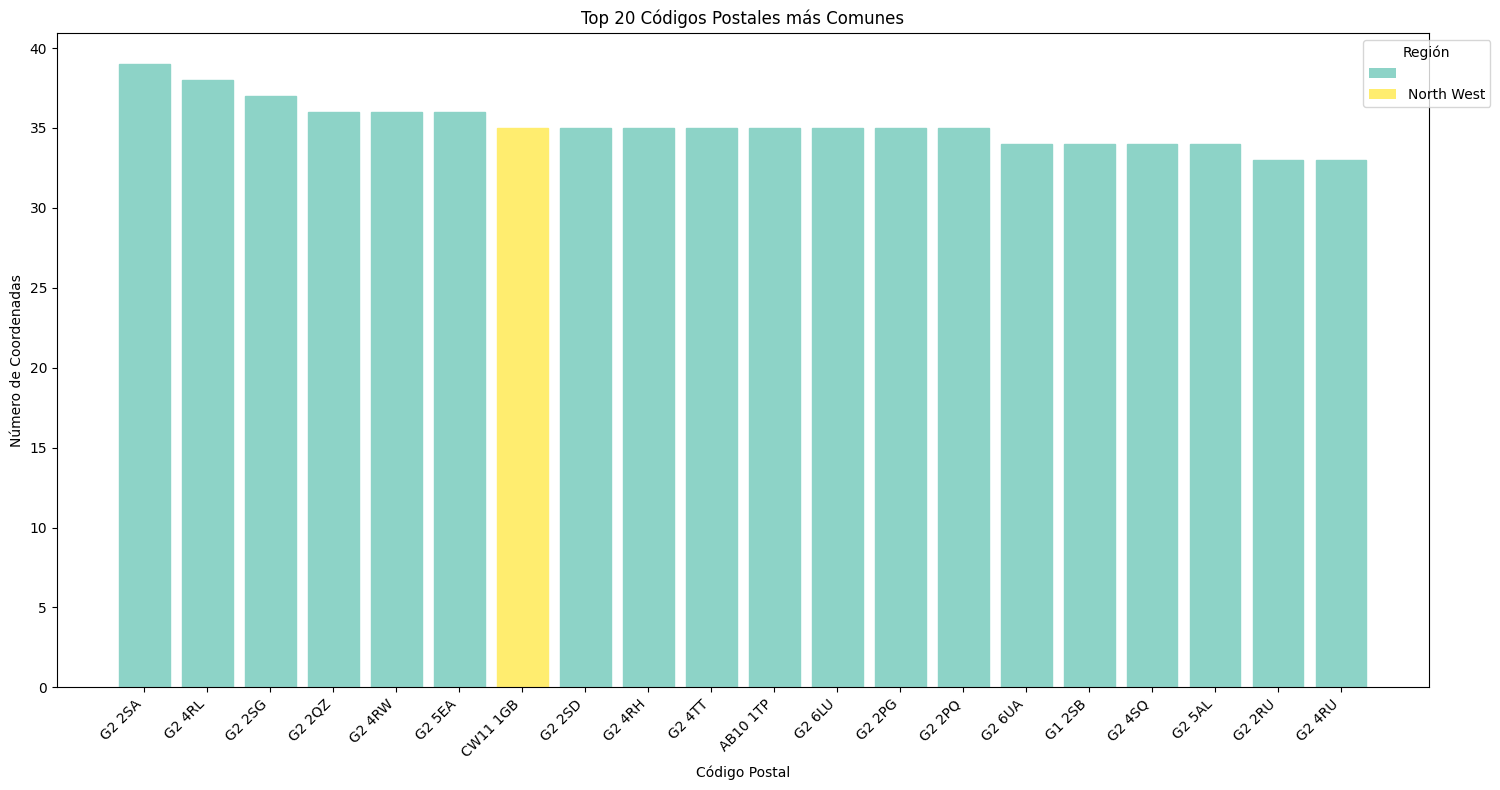

In [13]:
plt.figure(figsize=(15, 8))
bars = plt.bar(top_postcode_df['postcode'], top_postcode_df['coordinate_count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Códigos Postales más Comunes')
plt.xlabel('Código Postal')
plt.ylabel('Número de Coordenadas')

regions = top_postcode_df['region'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))
region_color_map = dict(zip(regions, colors))
for bar, region in zip(bars, top_postcode_df['region']):
    bar.set_color(region_color_map[region])
    
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=region) 
                  for region, color in region_color_map.items()]
plt.legend(handles=legend_elements, title='Región', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(
    data=region_country_analysis.head(10).to_pandas(),
    x='region',
    y='coordinate_count'
)
plt.title('Top 10 Regiones por Número de Coordenadas')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Región')
plt.ylabel('Número de Coordenadas')
plt.tight_layout()
plt.show()

# Estadisticos

## Calidad

In [70]:
stats_query = """
    WITH stats AS (
        SELECT 
            COUNT(DISTINCT rc.id) as total_coordinates,
            COUNT(DISTINCT cp.coordinate_id) as matched_coordinates,
            COUNT(DISTINCT rc.id) - COUNT(DISTINCT cp.coordinate_id) as unmatched_coordinates
        FROM raw_coordinates rc
        LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
    )
    SELECT 
        total_coordinates,
        matched_coordinates,
        unmatched_coordinates,
        ROUND((matched_coordinates::float / total_coordinates * 100)::numeric, 2)as match_percentage,
        ROUND((unmatched_coordinates::float / total_coordinates * 100)::numeric, 2)as unmatched_percentage
    FROM stats
"""

In [71]:
stats_df = pl.read_database(stats_query, conn)

In [72]:
print(stats_df.head())

shape: (1, 5)
┌───────────────────┬───────────────────┬───────────────────┬──────────────────┬───────────────────┐
│ total_coordinates ┆ matched_coordinat ┆ unmatched_coordin ┆ match_percentage ┆ unmatched_percent │
│ ---               ┆ es                ┆ ates              ┆ ---              ┆ age               │
│ i64               ┆ ---               ┆ ---               ┆ decimal[*,2]     ┆ ---               │
│                   ┆ i64               ┆ i64               ┆                  ┆ decimal[*,2]      │
╞═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════════╡
│ 2020643           ┆ 1756519           ┆ 264124            ┆ 86.93            ┆ 13.07             │
└───────────────────┴───────────────────┴───────────────────┴──────────────────┴───────────────────┘


# Analisis de errores

In [76]:
error_analisys_query = """
    WITH unmatched AS (
        SELECT rc.id
        FROM raw_coordinates rc
        LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
        WHERE cp.coordinate_id IS NULL
    )
    SELECT 
        el.error_type,
        COUNT(*) as error_count,
        ROUND((COUNT(*)::float / (SELECT COUNT(*) FROM unmatched) * 100)::numeric, 2) as error_percentage
    FROM unmatched u
    JOIN error_logs el ON u.id = el.coordinate_id
    GROUP BY el.error_type
    ORDER BY error_count DESC
"""

In [77]:
error_analisys = pl.read_database(error_analisys_query, conn)

In [78]:
print(error_analisys)

shape: (2, 3)
┌────────────┬─────────────┬──────────────────┐
│ error_type ┆ error_count ┆ error_percentage │
│ ---        ┆ ---         ┆ ---              │
│ str        ┆ i64         ┆ decimal[*,2]     │
╞════════════╪═════════════╪══════════════════╡
│ NO_RESULTS ┆ 44091       ┆ 17.07            │
│ API_ERROR  ┆ 2519        ┆ 0.98             │
└────────────┴─────────────┴──────────────────┘


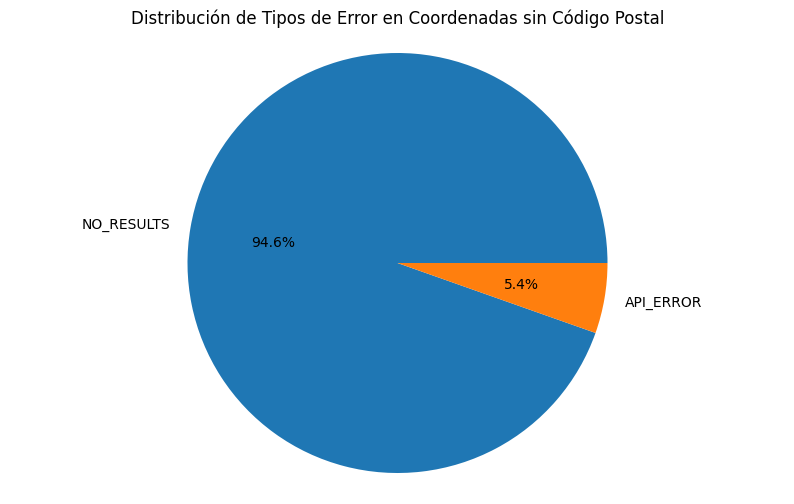

In [80]:
plt.figure(figsize=(10, 6))
plt.pie(error_analisys['error_count'], 
        labels=error_analisys['error_type'],
        autopct='%1.1f%%')
plt.title('Distribución de Tipos de Error en Coordenadas sin Código Postal')
plt.axis('equal')
plt.show()

## Distancias

In [17]:
distance_query = """
    SELECT distance 
    FROM coordinates_postcodes
"""

In [18]:
distance_df = pl.read_database(distance_query, conn)

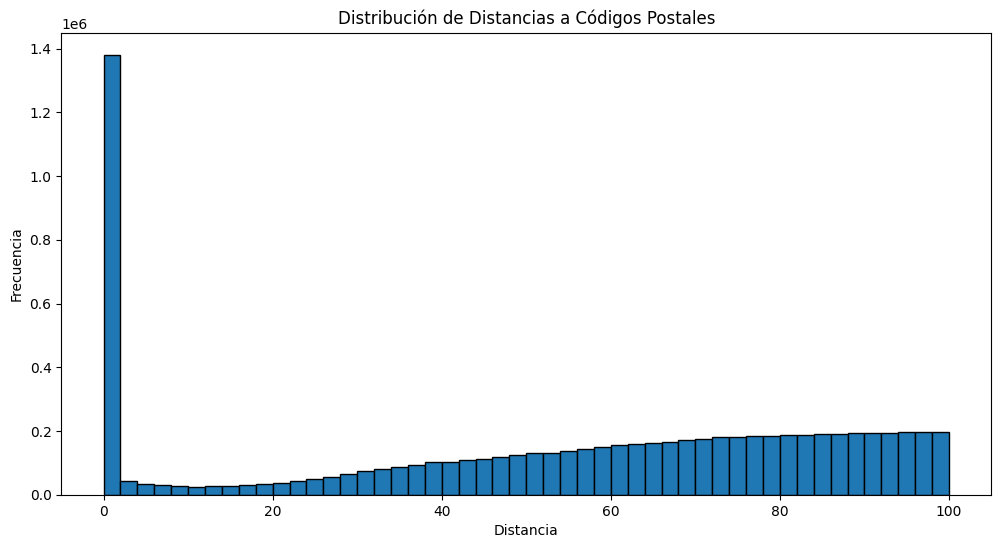

In [19]:
plt.figure(figsize=(12, 6))
plt.hist(distance_df['distance'], bins=50, edgecolor='black')
plt.title('Distribución de Distancias a Códigos Postales')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()

# Datos Enriquecidos

In [23]:
enriched_query = """
    SELECT 
        rc.latitude,
        rc.longitude,
        rc.file_path as source_file,
        pd.postcode,
        pd.country,
        pd.region,
        cp.distance,
        COALESCE(el.error_type, '') as error_type,
        COALESCE(cp.created_at, el.created_at) as processed_at
    FROM raw_coordinates rc
    LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
    LEFT JOIN postcode_details pd ON cp.postcode_id = pd.id
    LEFT JOIN error_logs el ON rc.id = el.coordinate_id
    ORDER BY processed_at
"""

In [24]:
enriched_data = pl.read_database(enriched_query, conn)

In [25]:
enriched_data.write_csv("../data/postcode_enriched_data.csv")

In [26]:
conn.close()